# Imports

In [1]:
import sys
import os
import warnings
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io
import subprocess
import scipy.fftpack as fft
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import pandas as pd
import scipy
from scipy.integrate import simps
import peakutils
from scipy.io import loadmat
from sklearn.linear_model import LinearRegression
import lmfit
import matplotlib as mpl
from matplotlib.widgets import Slider, Button
from mpl_toolkits.mplot3d import Axes3D 
from scipy.optimize import curve_fit
import scipy.signal as sig
from scipy.signal import find_peaks
import pybaselines as bl
sys.path.insert(0, os.path.abspath('imports'))
import suspect.base
import suspect
from suspect.mrsobjects import MRSBase, MRSData, MRSSpectrum
from scipy.io import savemat
##DESPERATE
import functions as proc
import wavelet_denoise as wave



# Functions to Read Brucker Data

In [2]:
def read_bruker_all_headers(study_directory, scan_no):
    """
    Reads and merges Bruker headers from multiple files for a given study directory and scan number.

    Parameters:
        study_directory (str): Path to the directory containing the Bruker study.
        scan_no (int): The scan number to process.

    Returns:
        dict: A dictionary containing merged header information from the subject, method, and acquisition parameter (acqp) files.
    """
    headers = {}

    # File paths
    method_path = os.path.join(study_directory, str(scan_no), 'method')
    acqp_path = os.path.join(study_directory, str(scan_no), 'acqp')
    subject_path = os.path.join(study_directory, 'subject')

    # Read headers
    method = read_bruker_header(method_path)
    acqp = read_bruker_header(acqp_path)
    subject = read_bruker_header(subject_path)

    # Merge headers
    headers.update(subject)
    duplicate_names = {'TITLE', 'JCAMPDX', 'DATATYPE', 'ORIGIN', 'OWNER'}

    # Remove duplicate keys from `method` and `acqp`
    method = {k: v for k, v in method.items() if k not in duplicate_names}
    acqp = {k: v for k, v in acqp.items() if k not in duplicate_names}

    # Update `headers` with `method` and handle conflicts
    for key, value in method.items():
        if key in headers:
            warnings.warn(
                f"*WARNING* {key} exists in both method and subject. Using value from method."
            )
        headers[key] = value

    # Update `headers` with `acqp` and handle conflicts
    for key, value in acqp.items():
        if key in headers:
            warnings.warn(
                f"*WARNING* {key} exists in both method/subject and acqp. Using value from acqp."
            )
        headers[key] = value

    return headers

def strtok(val, delims):
    """
    Tokenizes a string into substrings based on multiple delimiters.

    Parameters:
        val (list of str): A list of strings to tokenize.
        delims (list of str): A list of delimiter characters.

    Returns:
        list of str: A list of tokens after splitting by the delimiters.
    """
    for delim in delims:
        val = [subtoken for token in val for subtoken in token.split(delim) if subtoken.strip()]
    return val

def read_bruker_header(filepath):
    """
    Parses a Bruker header file into a dictionary format.

    Parameters:
        filepath (str): Path to the header file.

    Returns:
        dict: A dictionary containing parsed header data.

    Raises:
        FileNotFoundError: If the file at the specified path does not exist.
    """
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File not found: {filepath}")

    with open(filepath, 'r') as file:
        rawdata = file.read()

    rawitems = strtok([rawdata], ['##', '$$'])
    header_dict = {}

    for item in rawitems:
        if item.startswith((' @vis', 'END=', 'PVM_StartupShimList=')):
            continue

        # Parse name and value
        try:
            name, value = item.split('=', 1)
        except ValueError:
            continue

        name = name.replace('-', '_').replace(' ', '_').replace('$', '')

        if value.startswith('( '):  # Handle arrays
            try:
                size, values = value[2:].split(')', 1)
                size = list(map(int, size.split(',')))
                size += [1] * (2 - len(size))  # Ensure 2D size
                header_dict[name] = np.array(values.split(), dtype=float).reshape(size)
            except ValueError:
                header_dict[name] = value.strip('<>').replace('\n', '')
        else:  # Single value
            try:
                header_dict[name] = float(value)
            except ValueError:
                header_dict[name] = value.strip()

    # Flatten single-element arrays
    for key, value in header_dict.items():
        if isinstance(value, np.ndarray) and value.shape == (1, 1):
            header_dict[key] = value[0, 0]

    return header_dict


def read_bruker_readout(study_directory, scan_no):
    """
    Reads and processes the Bruker readout file to extract free induction decays (FIDs).

    Parameters:
        study_directory (str): Path to the directory containing the Bruker study.
        scan_no (int): The scan number to process.

    Returns:
        tuple: Contains the following elements:
            - np.ndarray: Complex FID data.
            - dict: Header information.
    """
    header = read_bruker_all_headers(study_directory, scan_no)
    n_points = int(header['PVM_SpecMatrix'])
    min_points = 128

    # Ensure `tmp_n_points` is a power of 2 and greater than or equal to `min_points`
    tmp_n_points = max(min_points, 2 ** int(np.ceil(np.log2(max(n_points, min_points)))))

    # Load the FID data
    fid_file = os.path.join(study_directory, str(scan_no), 'pdata', '1', 'fid_proc.64')
    with open(fid_file, 'rb') as f:
        raw_fid = np.fromfile(f, dtype=np.float64)

    # Convert raw data to complex format and reshape
    complex_fid = raw_fid[::2] + 1j * raw_fid[1::2]
    remainder = len(complex_fid) // tmp_n_points
    reshaped_fid = complex_fid[:remainder * tmp_n_points].reshape((remainder, tmp_n_points)).T
    fids = reshaped_fid[:n_points, :]

    return fids, header


def compute_ppm_axis(header, n_points):
    """
    Computes the parts per million (ppm) axis based on the header information and number of points.

    Parameters:
        header (dict): Header data containing spectral information.
        n_points (int): Number of points in the spectrum.

    Returns:
        np.ndarray: PPM axis values.    
    """
    ppm_axis = np.linspace(0.0, float(header['PVM_SpecSW']), n_points)
    #print(f'before calculating mean the ppm = {ppm_axis}')
    #print(f'mean ppm = {np.mean(ppm_axis)}')

    ppm_axis -= np.mean(ppm_axis)
    ppm_axis += header['PVM_FrqWorkOffsetPpm'][0]
    return ppm_axis


def read_NSPECT(study_directory, scan_no):
    """
    Processes Bruker NSPECT data to compute FIDs, spectra, ppm axis, and header information.

    Parameters:
        study_directory (str): Path to the directory containing the Bruker study.
        scan_no (int): The scan number to process.

    Returns:
        tuple: Contains the following elements:
            - np.ndarray: FIDs.
            - np.ndarray: Spectra.
            - np.ndarray: PPM axis.
            - dict: Header information.
    """
    fids, header = read_bruker_readout(study_directory, scan_no)
    n_points = int(header['PVM_SpecMatrix'])
    filter_points = 76

    # Process FIDs
    fids = np.roll(fids, -filter_points, axis=0)
    fids[-filter_points:] = 0

    # Compute spectra and ppm axis
    spects = np.fft.fftshift(np.fft.fft(fids, axis=0), axes=0)
    
   # print(float(header['PVM_SpecSW']))
    ppm_axis = compute_ppm_axis(header, n_points)
    #print(ppm_axis)

    return fids, spects, ppm_axis, header


def read_bruker_csi(study_directory, scan_no):
    """
    Processes Bruker Chemical Shift Imaging (CSI) data and computes spatial and spectral information.

    Parameters:
        study_directory (str): Path to the directory containing the Bruker study.
        scan_no (int): The scan number to process.

    Returns:
        tuple: Contains the following elements:
            - np.ndarray: FIDs.
            - np.ndarray: Spectra.
            - np.ndarray: X spatial axis.
            - np.ndarray: Y spatial axis.
            - np.ndarray: PPM axis.
            - dict: Header information.

    Raises:
        ValueError: If the header method does not match Bruker CSI.
    """
    fids, header = read_bruker_readout(study_directory, scan_no)

    if header['Method'] != '<Bruker:CSI>':
        raise ValueError(f"Header not for Bruker CSI method. Found: {header['Method']}")

    n_points = int(header['PVM_SpecMatrix'])
    filter_points = 76
    n_phase_encodes = header['PVM_EncMatrix']
    fov = header['PVM_Fov']

    # Process FIDs
    fids = np.roll(fids, -filter_points, axis=0)
    fids[-filter_points:] = 0
    fids = fids.reshape((n_points, int(n_phase_encodes[0]), int(n_phase_encodes[1])))

    # Compute spectra
    spects = np.fft.fftshift(np.fft.fft(fids, axis=0), axes=0)

    # Compute spatial axes
    x_axis = np.linspace(-float(fov[0]) / 2, float(fov[0]) / 2, int(n_phase_encodes[0]))
    y_axis = np.linspace(-float(fov[1]) / 2, float(fov[1]) / 2, int(n_phase_encodes[1]))
    ppm_axis = compute_ppm_axis(header, n_points)

    return fids, spects, x_axis, y_axis, ppm_axis, header


def read_bruker_study(study_dir):
    """
    Reads all scans in a Bruker study directory and prints information about each scan.

    Parameters:
        study_dir (str): Path to the Bruker study directory.

    Returns:
        None: Prints information about the scans in the study directory.
    """
    scans = sorted(int(folder.name) for folder in os.scandir(study_dir) if folder.is_dir() and folder.name.isdigit())
    
    for scan in scans:
        method_file = os.path.join(study_dir, str(scan), 'method')
        if os.path.isfile(method_file):
            tmp_header = read_bruker_header(method_file)
            print(f"Scan No: {scan} is a {tmp_header['Method']} Scan.")
        else:
            print(f"Scan No: {scan} has no header.")

def read_rawdata(study_directory, scan_no, n_of_av):
    # Read header and raw data (existing code)
    header = read_bruker_all_headers(study_directory, scan_no)
    n_points = int(header['PVM_SpecMatrix'])
    
    # Determine byte order
    bytorda = header.get('BYTORDA', 0)
    dtype = np.dtype('>i4') if bytorda == 1 else np.dtype('<i4')
    
    # Read rawdata.job0
    rawdata_path = os.path.join(study_directory, str(scan_no), 'rawdata.job0')
    with open(rawdata_path, 'rb') as f:
        raw_data = np.fromfile(f, dtype=dtype).astype(np.float64)
    
    # Validate and reshape data
    expected_length = 2 * n_points * n_of_av
    if len(raw_data) != expected_length:
        raise ValueError(f"Raw data length mismatch. Expected {expected_length}, got {len(raw_data)}.")
    
    raw_data_reshaped = raw_data.reshape(n_of_av, 2 * n_points)
    
    # Convert to complex FIDs
    fids = np.array([acq[::2] + 1j * acq[1::2] for acq in raw_data_reshaped], dtype=np.complex128).T
    
    # Apply processing: roll and zero-pad
    filter_points = 76  
    fids = np.roll(fids, -filter_points, axis=0)
    fids[-filter_points:, :] = 0 
    
    # Compute spectra
    spects = np.fft.fftshift(np.fft.fft(fids, axis=0), axes=0)
    
    ppm_axis = compute_ppm_axis(header, n_points)
    
    return fids, spects, ppm_axis, header

# Additional Functions for Data Analysis

In [3]:
def signaltonoise(ppm, spects_X, signal_i, signal_f, boolean=1, noise_i=None, noise_f=None):
    """
    Computes the signal-to-noise ratio (SNR) for specified spectral regions.

    Parameters:
        ppm (np.ndarray): The PPM (parts per million) axis values of the spectrum.
        spects_X (np.ndarray): The spectral data corresponding to the PPM axis.
        signal_i (float, optional): The starting value (in ppm) of the signal region.
        signal_f (float, optional): The ending value (in ppm) of the signal region.
        boolean (int, optional): Determines the noise region selection method:
                                 - 0: Explicit noise region specified by `noise_i` and `noise_f`.
                                 - 1(default): Noise region automatically inferred as all data outside the signal region.
        noise_i (float, optional): The starting value (in ppm) of the noise region. Only used if `boolean` is 0. Default is None.
        noise_f (float, optional): The ending value (in ppm) of the noise region. Only used if `boolean` is 0. Default is None.

    Returns:
        tuple: A tuple containing:
            - float: The computed signal-to-noise ratio (SNR).
            - float: The maximum amplitude of the signal region.
            - float: The noise level, calculated as the standard deviation of the noise region.
    """
    # Mask the signal and noise regions
    signal_mask = (ppm >= signal_i) & (ppm <= signal_f)
    if boolean == 0:
        noise_mask = (ppm >= noise_i) & (ppm <= noise_f)
    else:
        noise_mask = ~signal_mask
    # Extract the signal and noise data
    signal_data = spects_X[signal_mask]
    noise_data = spects_X[noise_mask]

    # Calculate the signal amplitude 
    signal_amplitude = np.max(signal_data)

    # Calculate the noise level (use standard deviation)
    noise_level = np.std(noise_data)

    # Compute SNR
    snr = signal_amplitude / noise_level

    return snr, signal_amplitude, noise_level

def find_ref_pow(study_dir, scan_no):
    """
    Finds and displays the reference power (`PVM_RefPowCh1`) for each scan in a Bruker study directory.

    Parameters:
    -----------
    study_dir : str
        The path to the Bruker study directory containing multiple scan folders.

    Behavior:
    ---------
    - Iterates through all scan folders in the specified study directory.
    - Reads the headers for each scan using `read_bruker_all_headers`.
    - Checks if the `PVM_RefPowCh1` parameter exists in the scan's header.
    - Prints the reference power value if found.
    - Prints an error message if the key is missing from the header.

    Output:
    -------
    The function prints the reference power (`PVM_RefPowCh1`) for each scan, or an error message if the parameter is not found.
    """
    key = 'PVM_RefPowCh1'
    header_dict = read_bruker_all_headers(study_dir, scan_no)
          
    if key in header_dict:
        return float(header_dict[key])
    else:
        return None
    
def write_LCMRAW(study_directory=None, scan_no=None, outfile=None):
    """
    Generates and writes an LCMRAW formatted file for spectroscopic data.
    Input Parameters:
        study_directory (str): 
            Path to the directory containing the spectroscopy study data.
        
        scan_no (int): 
            Identifier for the specific scan to read within the study directory.
        
        outfile (str): 
            Full path to the output file where the processed spectral data and header 
            will be saved.

    Outputs:
        None

    Behaviour:
        1. Validates the input parameters (`study_directory`, `scan_no`, and `outfile`). 
           If any of them is missing, a `ValueError` is raised.
        2. Reads spectral data (FIDs and spectrum) and metadata from the input file 
           using the `read_NSPECT` function.
        3. Extracts relevant metadata such as subject ID, dwell time, echo time, ramp time, 
           central frequency, bandwidth, and the sequence protocol name.
        4. Processes the FID data:
            - Separates the real and imaginary components of the spectral data.
            - Flattens the arrays and serializes them for output.
        5. Constructs a custom header (`SEQPAR` and `NMID` sections) containing metadata 
           in a specific format.
        6. Writes the spectral data (real and imaginary parts) to the output file in 
           a space-delimited format, prepended with the custom header.

    Notes:
        - The header format adheres to the requirements for LCMRAW files.
        - The real and imaginary components of the spectrum are written side by side.
        - spec2nii command when reading the RAW file line of hzppm reads in the last word
          of that line as a central frequency and assumes that the central frequency is given
          in MHz(while brucker has output in Hz). hence the HZPPPM= {le_HZPPPM:.16f}, {le_CENTRALFREQUENCY:.16f} 
          and multiplication of central frequency on 1E-6
    """
    if None not in (study_directory, scan_no, outfile):
        pass
    else:
        raise ValueError("Provide all three parameters: study_directory, scan_no and outfile")
    
    fids, spects, ppm_axis, header = read_NSPECT(study_directory,scan_no)

    nmid_id = header['SUBJECT_id']
    fmtdat = '6.3f'
    #volume = header['SliceGeoCub']
    tramp = header['PVM_RampTime']
    centralfrequency = header['PVM_FrqRef'][0].item()
    bandwidth=header['PVM_SpecSWH']*1E-6
    dwelltime = 1/bandwidth #float(header['PVM_SpecDwellTime'])
    hzpppm = header['PVM_FrqRefPpm'][0].item()
    seq=header['ACQ_protocol_name']

    Spectrum_real = np.real(fids).flatten()
    Spectrum_imag = np.imag(fids).flatten()
    Spectrum_serialized = np.column_stack((Spectrum_real, Spectrum_imag))
    Nbrfmt = '%' + fmtdat
    
    if 'EchoTime' in header:
        echotime=header['EchoTime']
        #HR modif Header
        Header = "\
        $SEQPAR\n\
        ECHOTIME= {le_TE:.16f}\n\
        DWELLTIME= {le_DWELLTIME:.16f}\n\
        HZPPPM= {le_HZPPPM:.16f}, {le_CENTRALFREQUENCY:.16f}\n\
        SEQ= {le_SEQ}\n\
        $END\n\
        $NMID\n\
        ID= '{le_ID}'\n\
        FMTDAT= '{le_FMTDAT}'\n\
        TRAMP= {le_TRAMP:.16f}\n\
        $END".format(
        le_TE=echotime,
        le_DWELLTIME=dwelltime*1E-6,
        le_HZPPPM=hzpppm,
        le_CENTRALFREQUENCY=centralfrequency*1E-6,
        le_SEQ=seq,
        le_ID=nmid_id,
        le_FMTDAT=Nbrfmt,
        le_TRAMP=tramp)
    else:
        #HR modif Header
        Header = "\
        $SEQPAR\n\
        DWELLTIME= {le_DWELLTIME:.16f}\n\
        HZPPPM= {le_HZPPPM:.16f}, {le_CENTRALFREQUENCY:.16f}\n\
        SEQ= {le_SEQ}\n\
        $END\n\
        $NMID\n\
        ID= '{le_ID}'\n\
        FMTDAT= '{le_FMTDAT}'\n\
        TRAMP= {le_TRAMP:.16f}\n\
        $END".format(
        le_DWELLTIME=dwelltime*1E-6,
        le_HZPPPM=hzpppm,
        le_CENTRALFREQUENCY=centralfrequency*1E-6,
        le_SEQ=seq,
        le_ID=nmid_id,
        le_FMTDAT=Nbrfmt,
        le_TRAMP=tramp)
    print(outfile)
    np.savetxt(outfile, Spectrum_serialized, fmt=Nbrfmt, delimiter='  ', newline='\n', header=Header, comments='')

    return

        
def run_terminal_command(command):
    """
    Executes a given command in the terminal.

    Parameters:
        command (str): The command to be executed in the terminal. It should be a valid shell command.
size
    Returns:
        dict: A dictionary containing:
            - 'stdout': The standard output of the command.
            - 'stderr': The standard error output of the command.
            - 'returncode': The exit status code of the command.

    Raises:
        ValueError: If the provided command is empty or not a string.
        Exception: If an unexpected error occurs during command execution.

    Example Usage:
        result = run_terminal_command("ls -l /path/to/directory")
        print("Output:", result['stdout'])
        print("Error:", result['stderr'])
        print("Exit Code:", result['returncode'])
    """
    if not command or not isinstance(command, str):
        raise ValueError("The command must be a non-empty string.")

    try:
        # Run the command and capture output and errors
        process = subprocess.run(
            command, 
            shell=True,            # Runs the command in a shell
            text=True,             # Ensures output is returned as a string
            capture_output=True    # Captures stdout and stderr
        )
        
        # Return the result as a dictionary
        return {
            "stdout": process.stdout.strip(),
            "stderr": process.stderr.strip(),
            "returncode": process.returncode
        }
    except Exception as e:
        raise Exception(f"An error occurred while executing the command: {e}")
    

def read_phase_corrected_spects(filepath):
    """
    Simple txt file reading function.

    FSLeyes, after phase correction, exports a file with 2 columns:
    - The first column represents the frequency values.
    - The second column contains the values of the phase-corrected real part of the spectrum.

    This function reads that file and extracts both columns into separate numpy arrays.

    Parameters:
    filepath (str): Path to the text file containing the phase-corrected spectrum.

    Returns:
    spects_phase_corrected (np.ndarray): Values of the phase-corrected real part of the spectrum.
    """
    data = np.loadtxt(filepath)  # Load the entire file as a 2D numpy array
    frequency_axis=data[:,0] 
    spects_phase_corrected = data[:, 1]  # Second column: phase-corrected spectrum

    return frequency_axis, spects_phase_corrected




#def simple(data)

def mag_real(data, *args, range_hz=None, range_ppm=None):
    """
    Estimates the zero and first order phase parameters which minimise the
    difference between the real part of the spectrum and the magnitude. Note
    that these are the phase correction terms, designed to be used directly
    in the adjust_phase() function without negation.
    
    Parameters
    ----------
    data: MRSBase
        The data to be phased
    range_hz: tuple (low, high)
        The frequency range in Hertz over which to compare the spectra
    range_ppm: tuple (low, high)
        The frequency range in PPM over which to compare the spectra. range_hz
        and range_ppm cannot both be defined.
    Returns
    -------
    phi0 : float
        The estimated zero order phase correction
    phi1 : float
        The estimated first order phase correction
    """
    if range_hz is not None and range_ppm is not None:
        raise KeyError("Cannot specify both range_hz and range_ppm")

    if range_hz is not None:
        frequency_slice = data.slice_hz(*range_hz)
    elif range_hz is not None:
        frequency_slice = data.slice_ppm(*range_ppm)
    else:
        frequency_slice = slice(0, data.np)

    def single_spectrum_version(spectrum):
        def residual(pars):
            par_vals = pars.valuesdict()
            phased_data = spectrum.adjust_phase(par_vals['phi0'],
                                                par_vals['phi1'])

            diff = np.real(phased_data) - np.abs(spectrum)

            return diff[frequency_slice]

        params = lmfit.Parameters()
        params.add('phi0', value=0.0, min=-np.pi, max=np.pi)
        params.add('phi1', value=0.0001, min=-0.0001, max=0.0001)

        result = lmfit.minimize(residual, params)
        return result.params['phi0'].value, result.params['phi1'].value

    return np.apply_along_axis(single_spectrum_version,
                               axis=-1,
                               arr=data.spectrum())


def ernst(data):
    """
    Estimates the zero and first order phase using the ACME algorithm, which
    minimises the integral of the imaginary part of the spectrum. Note that
    these are the phase correction terms, designed to be used directly in the
    adjust_phase() function without negation.

    Parameters
    ----------
    data: MRSBase
        The data to be phased
    range_hz: tuple (low, high)
        The frequency range in Hertz over which to compare the spectra
    range_ppm: tuple (low, high)
        The frequency range in PPM over which to compare the spectra. range_hz
        and range_ppm cannot both be defined.
    Returns
    -------
    phi0 : float
        The estimated zero order phase correction
    phi1 : float
        The estimated first order phase correction
    """
    def residual(pars):
        par_vals = pars.valuesdict()
        phased_data = data.adjust_phase(par_vals['phi0'],
                                        par_vals['phi1'])
        return np.sum(phased_data.spectrum().imag)

    params = lmfit.Parameters()
    params.add('phi0', value=0, min=-np.pi, max=np.pi)
    params.add('phi1', value=0.0, min=-0.0001, max=0.0001)

    result = lmfit.minimize(residual, params, method='simplex')
    return result.params['phi0'].value, result.params['phi1'].value


def acme(data, *args, range_hz=None, range_ppm=None, gamma=100):
    """
    Estimates the zero and first order phase using the ACME algorithm, which
    minimises the entropy of the real part of the spectrum. Note that these
    are the phase correction terms, designed to be used directly in the
    adjust_phase() function without negation.
    
    Parameters
    ----------
    data : MRSBase
        The data to be phased
    range_hz : tuple (low, high)
        The frequency range in Hertz over which to compare the spectra
    range_ppm : tuple (low, high)
        The frequency range in PPM over which to compare the spectra. range_hz
        and range_ppm cannot both be defined.
    gamma : float
        Weighting factor for penalty function.
    Returns
    -------
    phi0 : float
        The estimated zero order phase correction
    phi1 : float
        The estimated first order phase correction
    """
    if range_hz is not None and range_ppm is not None:
        raise KeyError("Cannot specify both range_hz and range_ppm")

    if range_hz is not None:
        frequency_slice = data.slice_hz(*range_hz)
    elif range_hz is not None:
        frequency_slice = data.slice_ppm(*range_ppm)
    else:
        frequency_slice = slice(0, data.np)

    def single_spectrum_version(spectrum):
        def residual(pars):
            par_vals = pars.valuesdict()
            phased_data = spectrum.adjust_phase(par_vals['phi0'],
                                                par_vals['phi1'])

            r = phased_data.real[frequency_slice]
            r = r / np.sum(r)
            derivative = np.abs((r[1:] - r[:-1]))
            derivative_norm = derivative / np.sum(derivative)

            # make sure the entropy doesn't blow up by removing 0 values
            derivative_norm[derivative_norm == 0] = 1

            entropy = -np.sum(derivative_norm * np.log(derivative_norm))

            # penalty function
            p = np.sum(r[r < 0] ** 2)

            return entropy + gamma * p

        params = lmfit.Parameters()
        params.add('phi0', value=0.0, min=-np.pi, max=np.pi)
        params.add('phi1', value=0.0001, min=-0.0001, max=0.0001)

        result = lmfit.minimize(residual, params, method='simplex')
        return result.params['phi0'].value, result.params['phi1'].value

    return np.apply_along_axis(single_spectrum_version,
                               -1,
                               data.spectrum())


def compare_headers(header1, header2):
    # Ensure both headers have the same keys
    if header1.keys() != header2.keys():
        print("Warning: The headers have different keys. Comparison may be incomplete.")

    # Iterate through the keys and compare values
    for key in header1:
        if key in header2:
            value1 = header1[key]
            value2 = header2[key]

            # Handle cases where values are NumPy arrays
            if isinstance(value1, np.ndarray) and isinstance(value2, np.ndarray):
                if not np.array_equal(value1, value2):
                    print(f"Difference found in key: {key}")
                    print(f"  header 1: {value1}")
                    print(f"  header 2: {value2}")
            else:
                # Handle non-array values
                if value1 != value2:
                    print(f"Difference found in key: {key}")
                    print(f"  header 1: {value1}")
                    print(f"  header 2: {value2}")
        else:
            print(f"Key '{key}' not found in 2")



# Dataset

### Rat 2 ISIS measurements

In [4]:
study_directory = '/home/asatiani/Desktop/Thesis/Experiment/Data/20250128_135429_RAT_2_JAN_28_RAT_2_2nd_test_head_supine_1_1/'
raw_output_directory='LCMRAW/'
spec2nii_output_directory='spec2nii/'
experiment_ID="InVivo_RAT_2_28Jan2025_Volume_Coil"
scans_of_interest=[15,16]

### Phantom 20mM Volume coil Jan14 2025 


In [14]:
study_directory = '/home/asatiani/Desktop/Thesis/Experiment/Data/20250114_141227_NADH_20mM_NADH_Jan14_31P_1_1/'
raw_output_directory='LCMRAW/'
spec2nii_output_directory='spec2nii/'
experiment_ID="20mM_14Jan2025_Volume_Coil"
scans_of_interest=np.arange(24, 38, 1)
scans_of_interest_for_ISIS = np.arange(10, 23, 1)

# Create LCM.raw files and prepare them for FSLeyes

In [ ]:
for scan_no in scans_of_interest:
    fids, spects, ppm_axis, header = read_NSPECT(study_directory,scan_no)
    output_filename = experiment_ID+'_'+str(scan_no)+'.RAW'
    run_terminal_command('mkdir '+raw_output_directory+experiment_ID)
    run_terminal_command('mkdir '+spec2nii_output_directory+experiment_ID)

    outfile = raw_output_directory+experiment_ID+'/'+output_filename
    print(header['PVM_FrqRef'][0])
    spec2nii='spec2nii raw -n 31P -o '+ spec2nii_output_directory+experiment_ID+' ' + outfile
    write_LCMRAW(study_directory,scan_no, outfile)
    run_terminal_command(spec2nii)


[202.52550873]
LCMRAW/20mM_14Jan2025_Volume_Coil/20mM_14Jan2025_Volume_Coil_10.RAW
[202.52550873]
LCMRAW/20mM_14Jan2025_Volume_Coil/20mM_14Jan2025_Volume_Coil_11.RAW
[202.52550873]
LCMRAW/20mM_14Jan2025_Volume_Coil/20mM_14Jan2025_Volume_Coil_12.RAW
[202.52550873]
LCMRAW/20mM_14Jan2025_Volume_Coil/20mM_14Jan2025_Volume_Coil_13.RAW
[202.52550873]
LCMRAW/20mM_14Jan2025_Volume_Coil/20mM_14Jan2025_Volume_Coil_14.RAW
[202.52550873]
LCMRAW/20mM_14Jan2025_Volume_Coil/20mM_14Jan2025_Volume_Coil_15.RAW
[202.52550873]
LCMRAW/20mM_14Jan2025_Volume_Coil/20mM_14Jan2025_Volume_Coil_16.RAW
[202.52550873]
LCMRAW/20mM_14Jan2025_Volume_Coil/20mM_14Jan2025_Volume_Coil_17.RAW
[202.52550873]
LCMRAW/20mM_14Jan2025_Volume_Coil/20mM_14Jan2025_Volume_Coil_18.RAW
[202.52550873]
LCMRAW/20mM_14Jan2025_Volume_Coil/20mM_14Jan2025_Volume_Coil_19.RAW
[202.52550873]
LCMRAW/20mM_14Jan2025_Volume_Coil/20mM_14Jan2025_Volume_Coil_20.RAW
[202.52550873]
LCMRAW/20mM_14Jan2025_Volume_Coil/20mM_14Jan2025_Volume_Coil_21.RAW
[202

## Check power ref values

In [12]:
scans = sorted(int(folder.name) for folder in os.scandir(study_directory) if folder.is_dir() and folder.name.isdigit())

print(f'In {experiment_ID} we have: \n')
read_bruker_study(study_directory)

for scn in scans_of_interest:
    fids, spects, ppm_axis, header = read_NSPECT(study_directory,scn)
    print(f'The power ref for scan N {scn} is {find_ref_pow(study_directory,scn)}')



In InVivo_RAT_2_28Jan2025_Volume_Coil we have: 

Scan No: 1 is a <Bruker:FLASH> Scan.
Scan No: 4 is a <Bruker:RARE> Scan.
Scan No: 5 is a <Bruker:RARE> Scan.
Scan No: 6 is a <Bruker:PRESS> Scan.
Scan No: 7 is a <Bruker:FieldMap> Scan.
Scan No: 9 is a <Bruker:PRESS> Scan.
Scan No: 10 is a <Bruker:PRESS> Scan.
Scan No: 11 is a <Bruker:PRESS> Scan.
Scan No: 12 is a <Bruker:PRESS> Scan.
Scan No: 13 is a <Bruker:PRESS> Scan.
Scan No: 14 is a <Bruker:PRESS> Scan.
Scan No: 15 is a <Bruker:ISIS> Scan.
Scan No: 16 is a <Bruker:ISIS> Scan.
The power ref for scan N 15 is 7.0
The power ref for scan N 16 is 5.0


# Check the Brucker Data Using Only Python

(1024, 1)


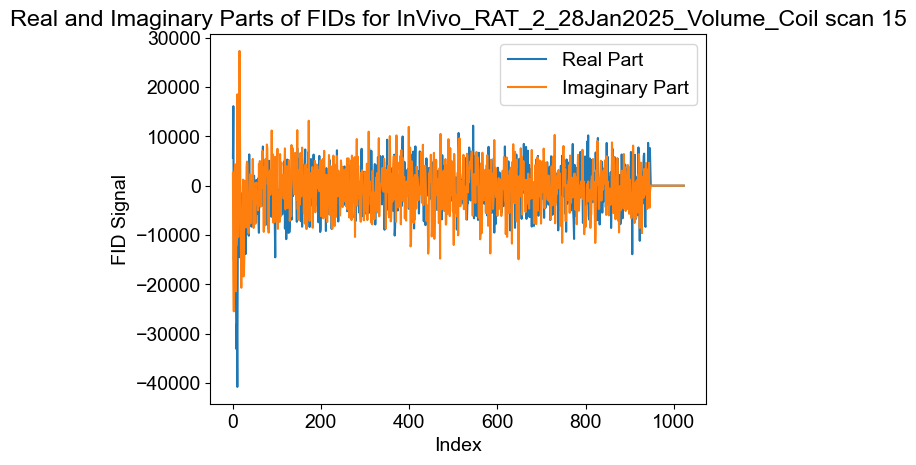

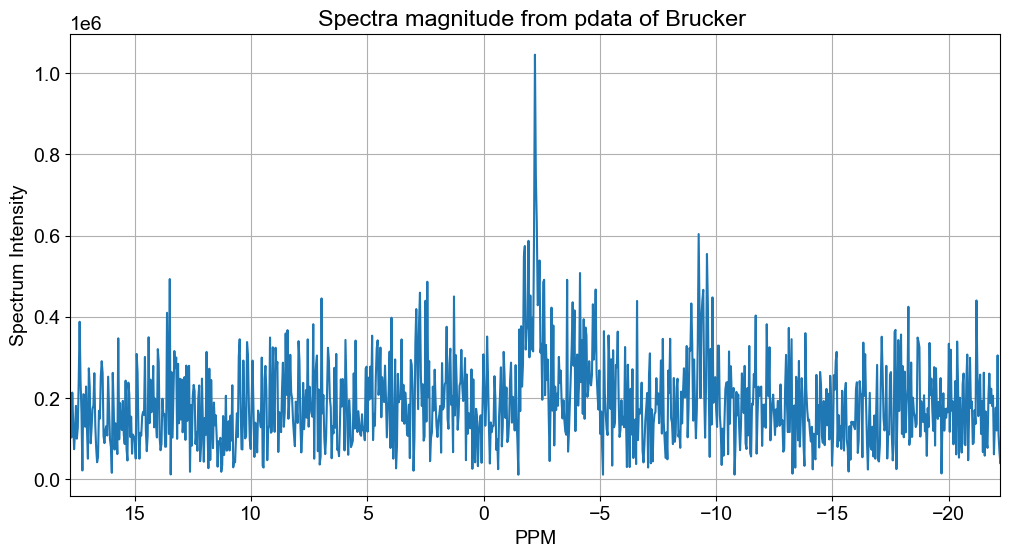

In [11]:
scan_number=15
fids, spects, ppm_axis, header = read_NSPECT(study_directory,scan_number) 
print(np.shape(fids))
# Line plot for real and imaginary parts of fids
plt.figure()
sns.lineplot(x=np.arange(int(header['PVM_SpecMatrix'])), y=np.real(fids[:, :]).flatten(), label="Real Part")
sns.lineplot(x=np.arange(int(header['PVM_SpecMatrix'])), y=np.imag(fids[:, :]).flatten(), label="Imaginary Part")
plt.xlabel("Index")
plt.ylabel("FID Signal")
plt.title(f'Real and Imaginary Parts of FIDs for {experiment_ID} scan {scan_number}')
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))
sns.lineplot(x=ppm_axis, y=np.abs(spects[:, :]).flatten())
plt.xlabel("PPM")
plt.xlim(20+header['PVM_FrqWorkOffsetPpm'][0],-20+header['PVM_FrqWorkOffsetPpm'][0])
plt.ylabel("Spectrum Intensity")
plt.title(f'Spectra magnitude from pdata of Brucker ')
plt.grid()
plt.show()


# Reading the rawdata.job0 file

(1024, 512)
(1024,)


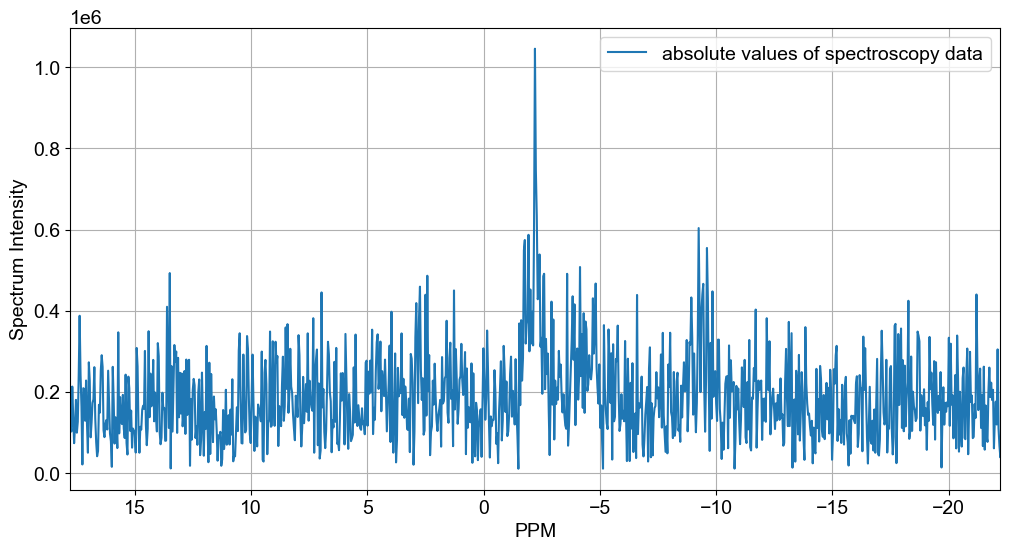

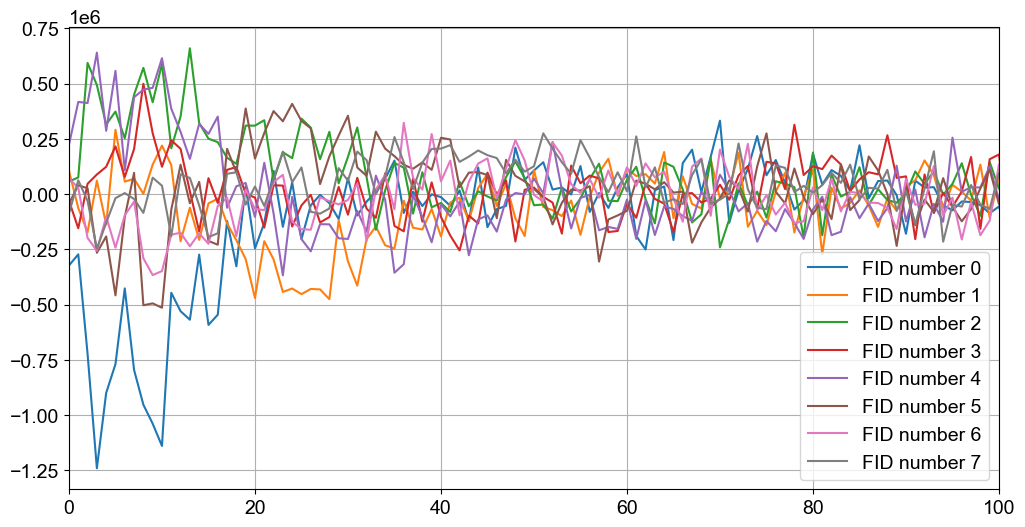

In [ ]:
scan = 15
fids_ISIS, spects_from_job0_ISIS, ppm_job0, header = read_rawdata(study_directory,scan, 512) 

plt.figure(figsize=(12, 6))
# sns.lineplot(x=ppm_job0, y=np.abs(shifted_avg_spects), label=f'first averaging out then shifting PCr to 0')
sns.lineplot(x=ppm_job0[:], y=np.abs(np.mean(spects_from_job0_ISIS, axis=1)), label=f'absolute values of spectroscopy data')
plt.xlabel("PPM")
plt.xlim(20+header['PVM_FrqWorkOffsetPpm'][0],-20+header['PVM_FrqWorkOffsetPpm'][0])
plt.ylabel("Spectrum Intensity")
#plt.ylim(-0.1e7,1.5e7)
# plt.title(f'Spectra magnitude from rawdata.job0 with first 10 FID points filtered')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))

for i in np.arange(0,8):
    sns.lineplot(x=np.arange(1024), y=np.real(fids_ISIS[:,i]), label=f'FID number {i}')
plt.grid()
plt.xlim(0,100)
plt.legend()
plt.show()

# SNR dependence on Power Reference

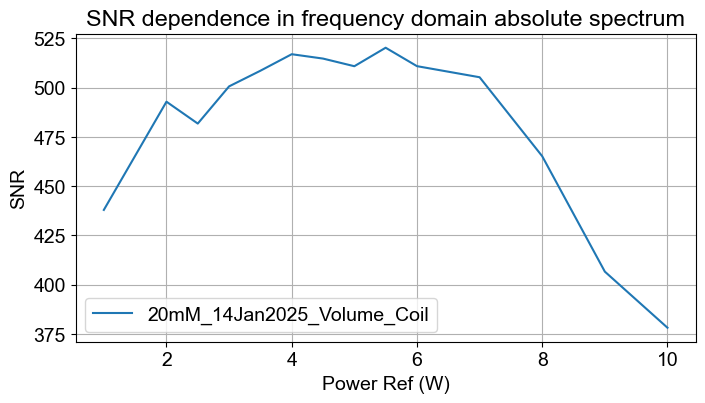

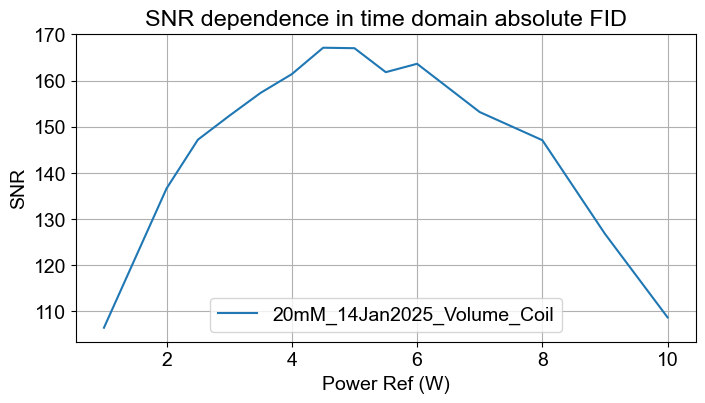

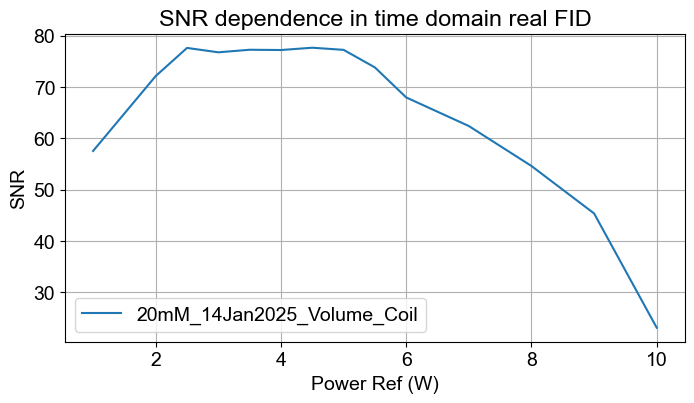

In [15]:
### SNR dependence on power ref extracted from absolute FID
data=[]
for scn in scans_of_interest:
    fids, spects, ppm_axis, header = read_NSPECT(study_directory,scn)
    snr, singal, noise = signaltonoise(ppm_axis, np.abs(spects),-15,-6)
    power_ref=find_ref_pow(study_directory,scn)
    data.append((power_ref,snr))
power_ref_val, snr_val = zip(*data)
plt.figure(figsize=(8, 4))
sns.lineplot(x=power_ref_val, y=snr_val, label=experiment_ID)
plt.xlabel("Power Ref (W)")
plt.ylabel("SNR")
plt.title(f'SNR dependence in frequency domain absolute spectrum')
plt.grid()
plt.show() 

data=[]

for scn in scans_of_interest:
    fids, spects, ppm_axis, header = read_NSPECT(study_directory,scn)
    snr, singal, noise = signaltonoise(np.arange(int(header['PVM_SpecMatrix'])), np.abs(fids),0,1200)
    power_ref=find_ref_pow(study_directory,scn)
    data.append((power_ref,snr))
power_ref_val, snr_val = zip(*data)
plt.figure(figsize=(8, 4))
sns.lineplot(x=power_ref_val, y=snr_val, label=experiment_ID)
plt.xlabel("Power Ref (W)")
plt.ylabel("SNR")
plt.title(f'SNR dependence in time domain absolute FID')
plt.grid()
plt.show() 

data=[]

for scn in scans_of_interest:
    fids, spects, ppm_axis, header = read_NSPECT(study_directory,scn)
    snr, singal, noise = signaltonoise(np.arange(int(header['PVM_SpecMatrix'])), np.real(fids),0,1200)
    power_ref=find_ref_pow(study_directory,scn)
    data.append((power_ref,snr))
power_ref_val, snr_val = zip(*data)
plt.figure(figsize=(8, 4))
sns.lineplot(x=power_ref_val, y=snr_val, label=experiment_ID)
plt.xlabel("Power Ref (W)")
plt.ylabel("SNR")
plt.title(f'SNR dependence in time domain real FID')
plt.grid()
plt.show() 

